## Do We Really Want Accurate Predictions?  
## The case for cost-minimizing loss functions

When using data to make predictions, one must decide what loss function to minimize.  This loss function determines the cost/benefit tradeoff to any change in the predictive model.  Traditionally the least squares loss function has been used to fit models, putting a greater penalty on predictions further from the actual value, and having identical penalties for all actual values.  In this notebook I will make a quick discussion on why this type of loss function is often not ideal for predictive models. 

These loss functions, like the least squares function for continous variables, evolved from a need to create models that were interpretable. In economics the focus is not on prediction, but rather on interpreting the model. In this case fitting a model needs to be fairly objective and free of bias, so that the interpretations are as close to \`actual' as possible. With prediction models we no longer care about interpreting the model. In many cases interpretation is not possible, or is very difficult (for example XGBoost and neural network implementations). In these cases we create very complex models that treat every error in an
equal prescribed manner. This may not be optimal, especially when the expected costs associated with errors differ across categories, or areas of the distribution of actual values.

As an example we will look at the Prudential dataset from the recent Kaggle competition.  

### Background on the Life Insurance Model
Before we begin, a brief overview of the problem that Prudential is facing.  In economics, this is called a principal-agent model.  Prudential is the principal and the consumer (applicant) is the agent.  The timing is as follows:  
1) User provides info

2) Prudential categorizes user as risk category $i$ and offers price $P_i$

3) User decides whether to accept or reject offer

We are assuming that the user provides accurate information, and that they decide whether or not to reject the offer given the price offered and their personal taste for risk.  Prudential's objective then is to categorize agents in a way that maximizes their profits, and given the categorization, they offer prices that maximize their expected profit.  

In this note I focus on the method of predicting the user's category, taking the categories as given.  Whether or not Prudential's categorization scheme is optimal would be an interesting area for research, but would require further data on users' mortality rates and risk preferences. 

### Prudential Insurance and the Weighted Kappa Loss Function

The Prudential life insurance competition was a recent Kaggle competition here participants competed to create the best predictive model for risk categories using supervised learning.  There were 8 risk categories, and the data was distributed as follows:

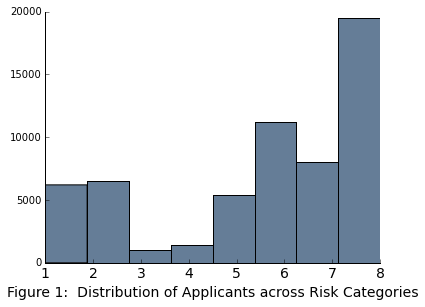

In [35]:
from numpy import loadtxt, zeros, ones, array, linspace, logspace
from pylab import scatter, show, title, xlabel, ylabel, plot, contour
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import linspace, polyval, polyfit, sqrt, stats, randn
%matplotlib inline
traindf = pd.read_csv("train.csv")

#Histogram for response variables to get an idea of distribution of response
plt.figure(figsize=(6,4.5))
plt.hist(traindf['Response'],color="#657d97", bins=8)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xticks(fontsize=14)
plt.xlabel('Figure 1:  Distribution of Applicants across Risk Categories', fontsize=14)


From a quick analysis of the data it appears that risk category 1 was the 'riskiest' category, and risk category 8 was the 'least risky' category.  For the purposes of this exposition we will make that assumption.  In figure 1 we see that assuming the categories are somewhat equally distributed across actual risk, the distribution of risk categories is very bi-modal.  This is likely to be the result of people selecting whether or not to apply for insurance, and may be a factor of Prudential's menu of offerings, or their price structure.  It could also be due to tastes for risk differing in an individual's actual risk.  

A population's risk is often assumed to follow the Weibull distribution, with the risk variable skewed towards less risky, and a long tail in terms of riskiness.  The distribution of types in the underlying population would thus look something like this:

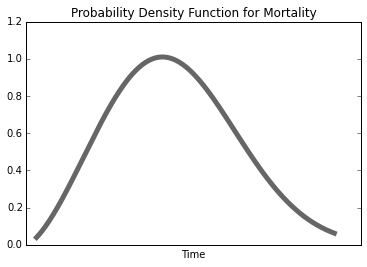

In [37]:
from scipy.stats import weibull_min
fig, ax = plt.subplots(1, 1)
c = 2.5
mean, var, skew, kurt = weibull_min.stats(c, moments='mvsk')

x = np.linspace(weibull_min.ppf(0.001, c),weibull_min.ppf(0.99, c), 300)
ax.plot(x, weibull_min.pdf(x, c),'k-', lw=5, alpha=0.6, label='weibull_min pdf')
ax.axes.get_xaxis().set_ticks([])
plt.title("Probability Density Function for Mortality")
plt.xlabel('Time')
plt.show()

For the purposes of our discussion, we'll assume that the expected cost of an insurance policy is linear in the risk of the customer.  Individuals with a risk factor of 2.0 have twice the expected cost of those with a risk factor of 1.0.  Prudential's risk categories can then be modelled as a series of risk cutoffs, cutting the distribution into eight segments.  Note that the highest risk category (risk category 1) necessarily captures the extended right tail of the distribution.  

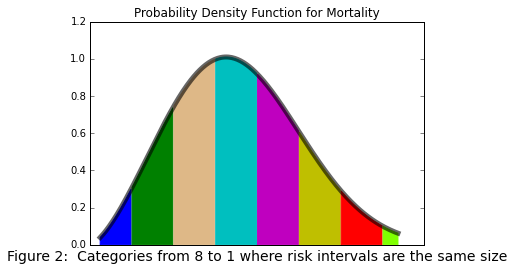

In [38]:
fig, ax = plt.subplots(1, 1)
c = 2.5
mean, var, skew, kurt = weibull_min.stats(c, moments='mvsk')

# cutoffs = frange(0.0,3.0,(i+1)/3)
x = np.linspace(weibull_min.ppf(0.001, c),weibull_min.ppf(0.99, c), 300)
ax.plot(x, weibull_min.pdf(x, c),'k-', lw=5, alpha=0.6, label='weibull_min pdf')
d = weibull_min.pdf(x,c)
pColor = ['b']
i=0
cutoff = []
for i in range(9):
    cutoff.append(i/4.0)
#pColor = ['b','g','burlywood','c','m','y','r','chartreuse']
pColor = ['b','g','burlywood','c','m','y','r','chartreuse']
for i in range(8):
    lb = cutoff[i]
    ub = cutoff[i+1]

    idx = np.searchsorted(x,[lb,ub])
    sx = x[idx[0]:idx[1]]
    sd = d[idx[0]:idx[1]]
    plt.fill_between(sx,sd,0,color = pColor[i])
plt.xlabel('Figure 2:  Categories from 8 to 1 where risk intervals are the same size', fontsize=14)
ax.axes.get_xaxis().set_ticks([])
plt.title("Probability Density Function for Mortality")
plt.show()

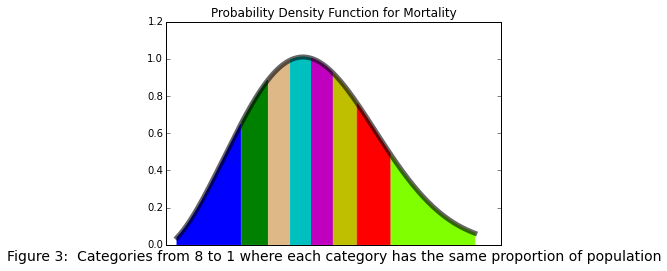

In [39]:
cutoffs = []
for i in range(7):
    cutoffs.append((i+1)/8.0)

#Conduct a bisection search to find eight equally likely intervals for our Weibull distribution:
riskCutoffs = [0]
c=2.5
for cutoff in cutoffs:
    Low = 0.0
    High = 3.0
    epsilon = 0.001
    while True:
        guess = (Low + High) / 2
        diff = weibull_min.cdf(guess,c) - cutoff
        if diff<0 and abs(diff)>epsilon:
            Low = guess
        elif diff>0 and abs(diff)>epsilon:
            High = guess
        else:
            riskCutoffs.append(guess)
            break
riskCutoffs.append(4.0)

#Graph distribution with categories shaded (categories go from 8 to 1, left to right)
fig, ax = plt.subplots(1, 1)
c = 2.5
mean, var, skew, kurt = weibull_min.stats(c, moments='mvsk')
x = np.linspace(weibull_min.ppf(0.001, c),weibull_min.ppf(0.99, c), 300)
ax.plot(x, weibull_min.pdf(x, c),'k-', lw=5, alpha=0.6, label='weibull_min pdf')
d = weibull_min.pdf(x,c)
pColor = ['b','g','burlywood','c','m','y','r','chartreuse']

for i in range(8):
    lb = riskCutoffs[i]
    ub = riskCutoffs[i+1]
    idx = np.searchsorted(x,[lb,ub])
    sx = x[idx[0]:idx[1]]
    sd = d[idx[0]:idx[1]]
    plt.fill_between(sx,sd,0,color = pColor[i])
plt.xlabel('Figure 3:  Categories from 8 to 1 where each category has the same proportion of population', fontsize=14)
ax.axes.get_xaxis().set_ticks([])
plt.title("Probability Density Function for Mortality")
plt.show()

If instead we want to create cutoffs that match our risk category histogram above, we are now assuming that all risk types are equally likely to apply for insurance, and the cutoffs would look as follows:

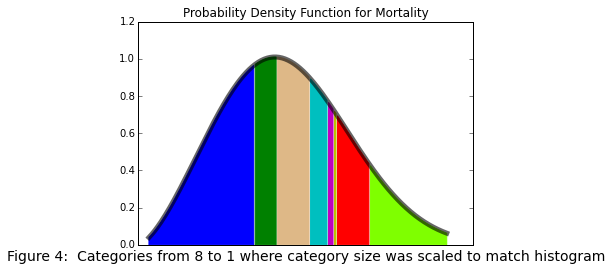

In [45]:
#Find the number of observations in each category and find the cumulative proportion from categories 8 to 1 (from least risky to most risky)
counts = traindf['Response'].value_counts()
propCounts = [0]
cumulativeCounts = []
cumulativeCount = 0
for i in range(7):
    propCount = float(counts[8-i]) / sum(counts)
    propCounts.append(propCount)
    cumulativeCount += propCount
    cumulativeCounts.append(cumulativeCount)
riskCutoffs2 = [0]

#Conduct a bisection search to find eight equally likely intervals for our Weibull distribution:
riskCutoff = 0
for cumulativeCount in cumulativeCounts[0:7]:
    Low = 0.0
    High = 3.0
    epsilon = 0.001
    while True:
        guess = (Low + High) / 2
        diff = weibull_min.cdf(guess,c) - cumulativeCount
        if diff<0 and abs(diff)>epsilon:
            Low = guess
        elif diff>0 and abs(diff)>epsilon:
            High = guess
        else:
            riskCutoffs2.append(guess)
            break
riskCutoffs2.append(4.0)

#Graph distribution with categories shaded (categories go from 8 to 1, left to right)
fig, ax = plt.subplots(1, 1)
c = 2.5
mean, var, skew, kurt = weibull_min.stats(c, moments='mvsk')
x = np.linspace(weibull_min.ppf(0.001, c),weibull_min.ppf(0.99, c), 200)
ax.plot(x, weibull_min.pdf(x, c),'k-', lw=5, alpha=0.6, label='weibull_min pdf')
d = weibull_min.pdf(x,c)
pColor = ['b','g','burlywood','c','m','y','r','chartreuse']
for i in range(8):
    lb = riskCutoffs2[i]
    ub = riskCutoffs2[i+1]
    idx = np.searchsorted(x,[lb,ub])
    sx = x[idx[0]:idx[1]]
    sd = d[idx[0]:idx[1]]
    plt.fill_between(sx,sd,0,color = pColor[i])
plt.xlabel('Figure 4:  Categories from 8 to 1 where category size was scaled to match histogram', fontsize=14)
ax.axes.get_xaxis().set_ticks([])
plt.title("Probability Density Function for Mortality")
plt.show()

From above we can see the small slivers of the distribution that would represent categories 4 and 3 (magenta and cyan) if the type of people who applied for insurance were distributed via the Weibull distribution.  If the underlying population is distributed via a Weibull distribution, it is unlikely that the categories are assigned such that categories 4 and 3 represent such a small interval of risk.  It is more likely that individuals with risk in categories 4 and 3 choose not to apply for insurance.  

In the Kaggle challenge, the loss function used to measure 'best' fit was the weighted kappa loss function.  It is designed to measure distance from the actual category (in a squared loss framework) and is normalized by the distribution of actual categories.  The equation for the kappa function is as follows:

$$ \kappa = 1 - \frac{\sum_{i,j}w_{i,j}O_{i,j}}{\sum_{i,j}w_{i,j}E_{i,j}}$$

The weight matrix $w_{i,j}$ puts a greater weight on predictions further from the actual risk category, and for any two categories $i$ and $j$ is the squared difference between the two, discounted by the number of categories, the weight is zero for when categories $i$ and $j$ are the same (i.e. accurate predictions).  The $O_{i,j}$ variable is a count of the number of observations that were actually category $i$ but were predicted to be category $j$.  The $E_{i,j}$ variable is the total number of observations predicted to be in category $j$ multiplied by the actual number of observations in category $i$, and accounts for how accurate you would be if you had randomly assigned predictions.  As a prediction improves the value of $\kappa$ increases, thus the highest value of $\kappa$ is considered the 'best fit'.

The main issue with the weighted kappa loss function from a business perspective is the symmetric treatment of prediction errors, both across the distribution of actual types, and errors in each direction.  In the next section I will discuss how these two issues create a loss of efficiency in terms of the insurance market.  

## The quadratic weighted kappa loss function and Economic Efficiency

There are two main areas where the quadratic weighted kappa loss function loses efficiency, and returns sub-optimal predictions where there are errors (i.e. when not all predictions are accurate).  The first is by weighting all deviations from actual predictions the same regardless of the actual prediction.  I will show that deviations from some actual predictions are more costly than deviations from others.  The second is that deviations are treated symmetrically, predicting one category lower than the actual risk bears the same penalty as predicting one category higher than actual risk.  

The traditional use of the Kappa, for determining the fit of the model, may no longer be appropriate with the progression of data science.  As new tools are being developed, and programming packages are becoming increasingly user friendly, the 'best-fit' is becoming more and more achievable.  Whether the Kappa is 0.6 or 0.7 may start to lose meaning, with the goal becoming simply the best kappa for a given weight matrix.  As I show in my note on the weighted kappa loss function, the Kappa is sensitive to seemingly trivial changes in prediction.  

### Effect of equal treatment across actual risk levels.
The weighted kappa loss function penalizes an $n$-category deviation from actual risk category 4 the same as they would an $n$-category deviation from actual risk category 1.  However, the costs associated with deviating from category 1 may be much larger than deviating from category 4.  For example, consider a 1-category deviation, where for an observation with actual risk category 4, the prediction is 3, and for an observation with actual risk category 1, the prediction is 2.  

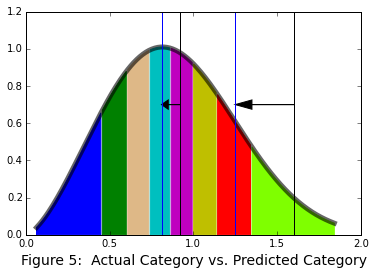

In [44]:
fig, ax = plt.subplots(1, 1)
c = 2.5
mean, var, skew, kurt = weibull_min.stats(c, moments='mvsk')
x = np.linspace(weibull_min.ppf(0.001, c),weibull_min.ppf(0.99, c), 200)
ax.plot(x, weibull_min.pdf(x, c),'k-', lw=5, alpha=0.6, label='weibull_min pdf')
d = weibull_min.pdf(x,c)
pColor = ['b','g','burlywood','c','m','y','r','chartreuse']

for i in range(8):
    lb = riskCutoffs[i]
    ub = riskCutoffs[i+1]
    idx = np.searchsorted(x,[lb,ub])
    sx = x[idx[0]:idx[1]]
    sd = d[idx[0]:idx[1]]
    plt.fill_between(sx,sd,0,color = pColor[i])
plt.xlabel('Figure 5:  Actual Category vs. Predicted Category', fontsize=14)
plt.plot((1.6, 1.6), (0, 1.2), 'k-')
plt.plot((1.25, 1.25), (0, 1.2), 'b-')
ax.arrow(1.6, 0.7, -0.25, 0, head_width=0.05, head_length=0.1, fc='k', ec='k')
ax.arrow(0.92, 0.7, -0.07, 0, head_width=0.05, head_length=0.04, fc='k', ec='k')


plt.plot((0.92, 0.92), (0, 1.2), 'k-')
plt.plot((0.81, 0.81), (0, 1.2), 'b-')
plt.show()

If we assume that expected cost of an insurance policy is linear in the risk level, we can see that the difference in expected cost between a prediction of 1, and a prediction of 2 is much greater than the difference between a prediction of 4 and a prediction of 5.  The cost of a 1-category error is much larger when the actual risk category is 1 than if the actual risk category is 4.

The second concern about the weighted kappa loss function is that errors are treated symmetrically, a prediction of 5 when the actual category is 4 has the same penalty as a prediction of 3 when the actual category is 4.  With insurance the direction of the error is very important.  Assuming that a prediction is used to determine the price of the policy, the prediction determines the revenue for the company, provided the consumer buys the policy.  The actual risk category determines the cost to the company.  

Predicting a risk category below the actual level (i.e. predicting the consumer is more risky than they actually are), will lead to a higher price for the consumer, and at some point, the consumer will choose not to buy the policy.  For the sake of our analysis, let's assume that the consumer will only buy the policy if the price is equal or lower to that of their actual risk category.  Then an error in prediction below the actual level will have a fixed cost of the foregone profits, regardless of the size of the error.  On the other hand, an error in prediction above the actual level will cause Prudential to lower the price of the policy due to the lower predicted risk.  This will cause a loss to Prudential, and the loss will be increasing in the prediction error.  

One way to control for these differences is to alter the weight matrix for the weighted kappa, so that the weight matrix truly represents the expected cost for each deviation.  In our example with the risk distributed by the Weibull distribution with a coefficient of 1.5, and assuming that all people are equally likely to apply for insurance, the weight matrix should look something like the following:

<html>

<body>
<table border="1" cellpadding="10" cellspacing="5" width="800" height="400">
<tr>
<td colspan = "2" rowspan = "2"></td>
<td colspan = "8"> Predicted Category</td>
</tr> 
<tr>
<td>1</td>
<td>2</td>
<td>3</td>
<td>4</td>
<td>5</td>
<td>6</td>
<td>7</td>
<td>8</td>
</tr>
<tr>
<td rowspan="8">Actual Category</td>
<td>1</td>
<td>0</td>
<td>$P_1-P_2$</td>
<td>$P_1-P_3$</td>
<td>$P_1-P_4$</td>
<td>$P_1-P_5$</td>
<td>$P_1-P_6$</td>
<td>$P_1-P_7$</td>
<td>$P_1-P_8$</td>
</tr>
<tr>
<td>2</td>
<td>$L_2$</td>
<td>0</td>
<td>$P_2-P_3$</td>
<td>$P_2-P_4$</td>
<td>$P_2-P_5$</td>
<td>$P_2-P_6$</td>
<td>$P_2-P_7$</td>
<td>$P_2-P_8$</td>
</tr>
<tr>
<td>3</td>
<td>$L_3$</td>
<td>$L_3$</td>
<td>0</td>
<td>$P_3-P_4$</td>
<td>$P_3-P_5$</td>
<td>$P_3-P_6$</td>
<td>$P_3-P_7$</td>
<td>$P_3-P_8$</td>
</tr>
<tr>
<td>4</td>
<td>$L_4$</td>
<td>$L_4$</td>
<td>$L_4$</td>
<td>0</td>
<td>$P_4-P_5$</td>
<td>$P_4-P_6$</td>
<td>$P_4-P_7$</td>
<td>$P_4-P_8$</td>
</tr>
<tr>
<td>5</td>
<td>$L_5$</td>
<td>$L_5$</td>
<td>$L_5$</td>
<td>$L_5$</td>
<td>0</td>
<td>$P_5-P_6$</td>
<td>$P_5-P_7$</td>
<td>$P_5-P_8$</td>
</tr>
<tr>
<td>6</td>
<td>$L_6$</td>
<td>$L_6$</td>
<td>$L_6$</td>
<td>$L_6$</td>
<td>$L_6$</td>
<td>0</td>
<td>$P_6-P_7$</td>
<td>$P_6-P_8$</td>
</tr>
<tr>
<td>7</td>
<td>$L_7$</td>
<td>$L_7$</td>
<td>$L_7$</td>
<td>$L_7$</td>
<td>$L_7$</td>
<td>$L_7$</td>
<td>0</td>
<td>$P_7-P_8$</td>
</tr>
<tr>
<td>8</td>
<td>$L_8$</td>
<td>$L_8$</td>
<td>$L_8$</td>
<td>$L_8$</td>
<td>$L_8$</td>
<td>$L_8$</td>
<td>$L_8$</td>
<td>0</td>
</tr>
</table>
</body>
</html>

Here $L_i$ is the foregone profit Prudential could have made from predicting the risk category accurately (if $i=3$ this foregone profit is the price of an insurance policy for someone with risk category 3 less the expected cost of someone in risk category 3.   $P_i$ is the price of an insurance policy for womeone with risk category $i$.  

Now let's think about how changing the weight function will affect our predictions.  In order to show that the new weight matrix is more efficient, we need to show that predictions made with this matrix have lower expected cost than predictions made with the weighted kappa loss function with the original weight matrix.  Let's consider a change at the margin that will shift an observation with predicted category 6 and actual category 4 to a prediction of 5, and will shift an observation with predicted category 3 and actual category 4 to a prediction of 2.  The original weight matrix tells us that these shifts will have no effect on the value of Kappa, but with our amended weight matrix, we can see that this change will decrease the loss by $P_5 - P_6$, a positive change.  Thus the predictions with our new weight matrix will increase efficiency compared with the original weight matrix.

Overall we can see that the choice of the loss function is fundamental when doing predictive analytics.  It can have large effects on the predictions, and significant impact on the company's bottom line.  In the Prudential example it is clear that were Prudential to rely on computer predictions, a quadratic weighted kappa loss function would not be optimal.  